In [43]:
from collections import Counter
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import torch
import torchaudio

# General

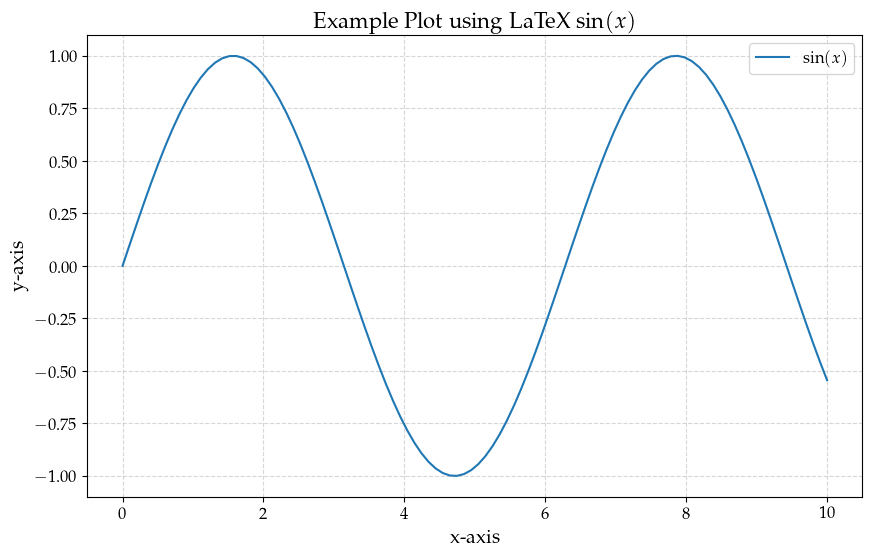

In [44]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Configure Matplotlib settings
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Use a serif font
    "font.serif": ["Palatino"],  # Set a specific serif font
    "axes.titlesize": 16,  # Title font size
    "axes.labelsize": 14,  # Axis label font size
    "xtick.labelsize": 12,  # X tick label font size
    "ytick.labelsize": 12,  # Y tick label font size
    "legend.fontsize": 12,  # Legend font size
    "figure.figsize": (10, 6),  # Figure size
    "axes.grid": True,  # Enable grid
    "grid.alpha": 0.5,  # Grid transparency
    "grid.linestyle": "--"  # Grid line style
})

# Example plot to demonstrate the settings
x = np.linspace(0, 10, 100)
y = np.sin(x)

fig, ax = plt.subplots()
ax.plot(x, y, label=r'$\sin(x)$')

# Adding title and labels
ax.set_title(r'Example Plot using LaTeX $\sin(x)$')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')

# Adding legend
ax.legend()

# Show plot
plt.show()


### Dataset

In [65]:
import ast

spd = pd.read_csv('data/Sleep_FullDataset_withDuplicates.csv')
spd = spd.drop_duplicates(subset='TrackID', keep='first')

def safe_literal_eval(val):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return ['unknown']  # or you can return an empty list or any default value
        
spd['Genres'] = spd['Genres'].apply(safe_literal_eval)

In [67]:
import pandas as pd
from collections import Counter

excluded_genres = ['punk', 'funk', 'alternative', 'metal', 'electronic', 'house', 'r&b', 'rock', 'rap', 'pop', 'hip hop', 'urban', 'edm', 'dance', 'unknown']

# Flatten the list of genres
all_genres = [genre for genres_list in spd['Genres'] for genre in genres_list]
genre_counter = Counter(all_genres)

# Function to check if a genre contains any excluded subword
def is_excluded(genre, excluded_genres):
    for subword in excluded_genres:
        if subword in genre:
            return True
    return False

# Separate included and excluded genres
included_counts = {genre: count for genre, count in genre_counter.items() if not is_excluded(genre, excluded_genres)}
excluded_counts = {genre: count for genre, count in genre_counter.items() if is_excluded(genre, excluded_genres)}

# Function to check if all genres in a row are included
def all_genres_included(genres, excluded_genres):
    return all(not is_excluded(genre, excluded_genres) for genre in genres)

# Filter the DataFrame for rows with only included genres
included_rows = spd[spd['Genres'].apply(lambda genres: all_genres_included(genres, excluded_genres))]

# Count the number of such rows
included_rows_count = len(included_rows)

print("Included counts:", included_counts)
print("Excluded counts:", excluded_counts)
print("Count of rows with only included genres:", included_rows_count)


Included counts: {'ambient': 1890, 'compositional ambient': 2709, 'drift': 2189, 'drone': 911, 'background music': 1118, 'dayton indie': 2, 'chill beats': 23, 'sleep': 23017, 'atmosphere': 643, 'healing': 650, 'meditation': 1139, 'new age': 1223, 'melancholia': 310, 'oxford indie': 73, 'permanent wave': 470, 'drone ambient': 42, 'vapor twitch': 299, 'focus': 1160, 'chill out': 219, 'water': 50, 'background piano': 473, 'fourth world': 462, 'calming instrumental': 2212, 'asmr': 58, 'boy band': 320, 'talent show': 187, 'british soul': 139, 'neo mellow': 1752, 'neo soul': 411, 'electro': 18, 'contemporary country': 1057, 'country': 842, 'country dawn': 147, 'country road': 795, 'indiecoustica': 774, 'neo-classical': 2235, 'new age piano': 618, 'ambient worship': 684, 'dreamo': 284, 'indie anthem-folk': 927, 'la indie': 87, 'downtempo': 376, 'ninja': 58, 'nu jazz': 73, 'swedish indie folk': 47, 'indie folk': 1651, 'stomp and holler': 1159, 'australian country': 36, 'japanese chillhop': 915

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

def plot_genre_counts(spd, excluded_genres):
    
    df = spd.copy()
    def safe_literal_eval(val):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return ['unknown']  # or you can return an empty list or any default value
          
    df['Genres'] = df['Genres'].apply(safe_literal_eval)
    df = df[df['Genres'].apply(lambda x: x != ['unknown'])]
        
    # Combine all genres into a single list and count them
    all_genres = [genre for genres_list in df['Genres'] for genre in genres_list]
    genre_counter = Counter(all_genres)

    # Function to check if a genre contains any excluded subword
    def is_excluded(genre, excluded_genres):
        for subword in excluded_genres:
            if subword in genre:
                return True
        return False

    # Escape special characters (though we'll disable LaTeX rendering to avoid issues)
    def escape_special_chars(text):
        return text.replace('&', r'\&').replace('%', r'\%').replace('$', r'\$').replace('#', r'\#').replace('_', r'\_').replace('{', r'\{').replace('}', r'\}').replace('~', r'\~').replace('^', r'\^').replace('\\', r'\\')

    # Separate included and excluded genres
    included_counts = {escape_special_chars(genre): count for genre, count in genre_counter.items() if not is_excluded(genre, excluded_genres)}
    excluded_counts = {escape_special_chars(genre): count for genre, count in genre_counter.items() if is_excluded(genre, excluded_genres)}

    # Create data for plotting
    all_genres = list(included_counts.keys()) + list(excluded_counts.keys())
    all_counts = list(included_counts.values()) + list(excluded_counts.values())
    all_colors = ['#2689ad'] * len(included_counts) + ['#FF6961'] * len(excluded_counts)  # Pastel blue and red
    
    # Combine genres and counts into a DataFrame for sorting
    plot_df = pd.DataFrame({'Genre': all_genres, 'Count': all_counts, 'Color': all_colors})
    plot_df = plot_df.sort_values(by='Count', ascending=False).head(50)  # Only take the top 50 genres
    
    # Disable LaTeX rendering globally
    plt.rcParams['text.usetex'] = False
    
    # Plotting
    plt.figure(figsize=(12, 7))
    bars = plt.bar(plot_df['Genre'], plot_df['Count'], color=plot_df['Color'], alpha=0.7)  # Set transparency with alpha
    
    # Apply hatched pattern to red bars
    for bar, color in zip(bars, plot_df['Color']):
        if color == '#FF6961':
            bar.set_hatch('//')
    
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.title('Genre Counts')
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#AEC6CF', edgecolor='#AEC6CF', label='Included Genres'),
                       Patch(facecolor='#FF6961', edgecolor='#FF6961', hatch='//', label='Excluded Genres')]
    plt.legend(handles=legend_elements)
    
    plt.tight_layout()  # Adjust the layout
    plt.savefig('genre_counts.png', dpi=300)
    plt.show()
    
    return genre_counter


findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following 

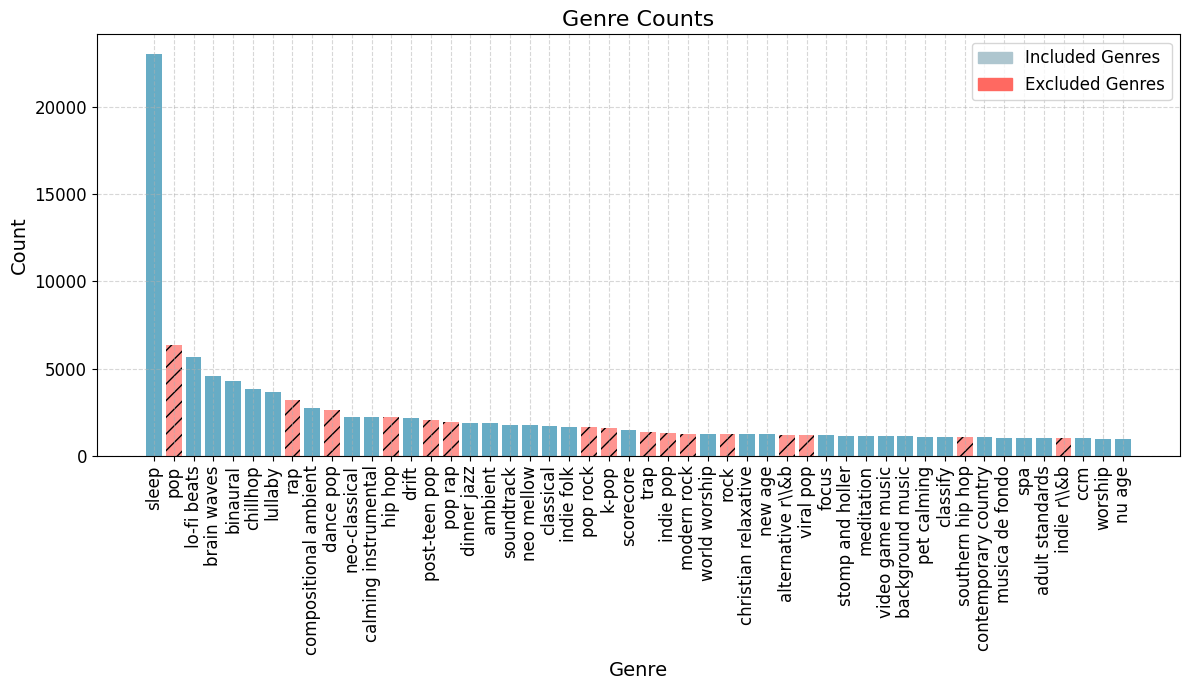

In [60]:
excluded_genres = ['punk', 'funk', 'alternative', 'metal', 'electronic', 'house', 'r&b', 'rock', 'rap', 'pop', 'hip hop', 'urban', 'edm', 'dance']

all_genres = plot_genre_counts(spd, excluded_genres)

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None  # or you can return an empty list or any default value


spd['Genres'] = spd['Genres'].apply(safe_literal_eval)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re

def sanitize_text(text):
    # Remove problematic characters for LaTeX
    text = re.sub(r'[&%$#_{}]', '', text)
    return text

def plot_genre_counts(df, excluded_genres):
    # Sanitize genres
    df['Genres'] = df['Genres'].apply(lambda genres: [sanitize_text(genre) for genre in genres])
    
    # Extract all genres and count them
    genre_counter = Counter(genre for genres_list in df['Genres'] for genre in genres_list)
    
    # Separate included and excluded genres
    included_counts = {genre: count for genre, count in genre_counter.items() if genre not in excluded_genres}
    excluded_counts = {genre: count for genre, count in genre_counter.items() if genre in excluded_genres}
    
    # Create data for plotting
    all_genres = list(included_counts.keys()) + list(excluded_counts.keys())
    all_counts = list(included_counts.values()) + list(excluded_counts.values())
    all_colors = ['blue'] * len(included_counts) + ['orange'] * len(excluded_counts)
    
    # Combine genres and counts into a DataFrame for sorting
    plot_df = pd.DataFrame({'Genre': all_genres, 'Count': all_counts, 'Color': all_colors})
    plot_df = plot_df.sort_values(by='Count', ascending=False)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    plt.bar(plot_df['Genre'], plot_df['Count'], color=plot_df['Color'])
    plt.xlabel('Genre')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.title('Genre Counts', usetex=False)  # Disable LaTeX rendering
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', edgecolor='blue', label='Included Genres'),
                       Patch(facecolor='orange', edgecolor='orange', label='Excluded Genres')]
    plt.legend(handles=legend_elements)
    
    plt.show()

findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino


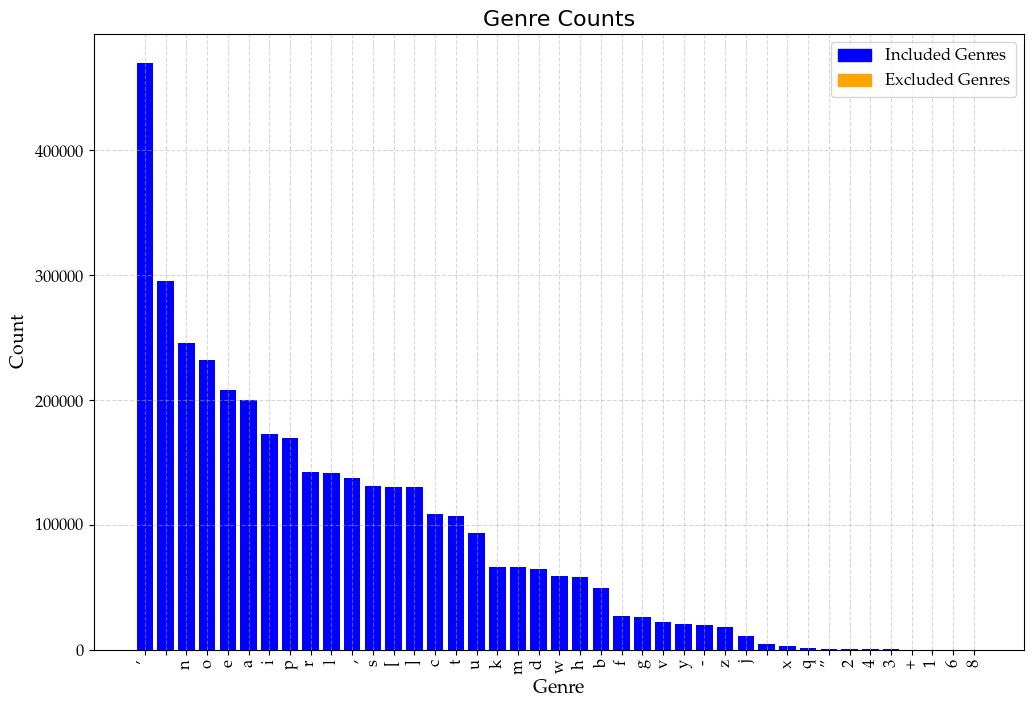

In [17]:
excluded_genres = ['punk', 'funk', 'alternative', 'metal', 'electronic', 'house', 'r&b', 'rock', 'rap', 'pop', 'hip hop']

plot_genre_counts(spd, excluded_genres)

In [3]:
spd.shape

(130308, 28)

In [18]:
import requests

# URL from your dataframe
url = spd.loc[2, 'SampleURL']

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Get the content of the response
    audio_content = response.content
    
    # Write the content to a file
    with open('output_audio.wav', 'wb') as audio_file:
        audio_file.write(audio_content)
    print("Audio file downloaded successfully.")
else:
    print("Failed to retrieve the audio. Status code:", response.status_code)


Audio file downloaded successfully.


In [19]:
Counter(spd['TrackName'])

Counter({'Sleeping Music': 654,
         'Sleep Music': 595,
         'Deep Sleep': 592,
         'Music For Sleep': 481,
         'Sleep Aid': 345,
         'Relaxing Music': 303,
         'Ambient Music': 286,
         'Dynamite': 260,
         'Music For Sleeping': 259,
         'Binaural Beats': 248,
         'Deep Sleep Aid': 236,
         'Calm Music': 219,
         'Calm Sleeping Music': 213,
         'Calm Music For Sleep': 211,
         'Binaural Beats Sleep Aid': 195,
         'Deep Sleep Music': 188,
         'Home': 174,
         'Ambient Sleep Music': 168,
         'Soothing Music For Sleep': 167,
         'Soothing Music': 156,
         'Calm Sleep Music': 151,
         'Sleep': 146,
         'Alpha Waves': 145,
         'Relaxing Sleeping Music': 138,
         'Lullaby': 136,
         'Binaural Beats and Brainwave Entrainment': 134,
         'Soothing Sleep Music': 129,
         'Soothing Sleeping Music': 127,
         'Sleeping Music For Sleep': 123,
         'Baby Lull

### Torch

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Transform the data to torch.FloatTensor and normalize it
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Downloaded CIFAR10 dataset.")


100%|██████████| 170498071/170498071 [00:14<00:00, 11960509.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Downloaded CIFAR10 dataset.


In [5]:
import os
import torch
import torchaudio

# Define the path to save the data
data_folder = './data/speechcommands'
os.makedirs(data_folder, exist_ok=True)

# Download and load the training data
trainset = torchaudio.datasets.SPEECHCOMMANDS(root=data_folder, url='speech_commands_v0.02', download=True, subset='training')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Download and load the validation data
valset = torchaudio.datasets.SPEECHCOMMANDS(root=data_folder, url='speech_commands_v0.02', download=True, subset='validation')

valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False, num_workers=2)

# Download and load the test data
testset = torchaudio.datasets.SPEECHCOMMANDS(root=data_folder, url='speech_commands_v0.02', download=True, subset='testing')

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

print("Downloaded SPEECHCOMMANDS dataset.")


100%|██████████| 2.26G/2.26G [01:22<00:00, 29.5MB/s] 


Downloaded SPEECHCOMMANDS dataset.


### Visualizing (lol?) Dataset

(tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [2.0023e-03, 4.8506e-08, 1.6935e-09,  ..., 1.3588e-09,
          2.0616e-06, 1.5228e-04],
         [2.4747e-03, 4.4818e-09, 4.3345e-08,  ..., 6.4700e-11,
          9.6698e-07, 1.5507e-04],
         [2.5268e-03, 2.3036e-10, 9.9184e-08,  ..., 5.3330e-11,
          7.9528e-07, 1.0238e-04]]]), 44100)


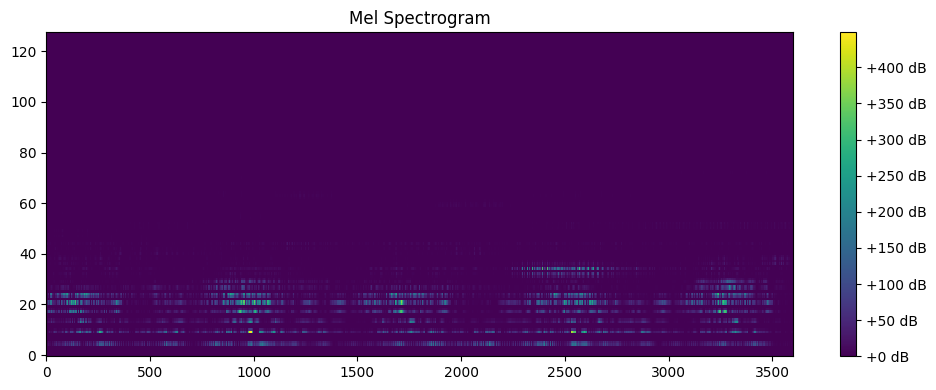

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load the tensor
mel_spectrogram = torch.load('cache/data/spotify_sleep_dataset/mel-spectrogram/0_tensor.pt')
print(mel_spectrogram)
# Step 2: Convert the tensor to a NumPy array (if it's not already) and select one channel (e.g., the first channel)
mel_spectrogram = mel_spectrogram[0][0].numpy()  # This selects the first channel

# Step 3: Plot the Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram, aspect='auto', origin='lower', interpolation='none')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


### Convert pt to wav

In [3]:
def convert_tensor_to_wav(tensor_file_path, wav_file_path):
    # Load the tensor and sample rate
    # print(torch.load(tensor_file_path))
    sample_rate = 22048
    waveform = torch.load(tensor_file_path)
    print(sample_rate)

    # Save the waveform as a .wav file
    torchaudio.save(wav_file_path, waveform, sample_rate)

In [5]:
tensor_file_path = 'data/test_generated/sample_62.pt'  # Update this path
wav_file_path = tensor_file_path.replace('.pt', '.wav')

convert_tensor_to_wav(tensor_file_path, wav_file_path)

22048


In [6]:
for i in range(0, 9):
    tensor_file_path = f'data/test_from_devgpu/sample_{i}.pt'
    wav_file_path = tensor_file_path.replace('.pt', '.wav')

    convert_tensor_to_wav(tensor_file_path, wav_file_path)

22048
22048
22048
22048
22048
22048
22048
22048
22048


In [6]:
import torch

# Load the file
pt_file, sample_rate = torch.load("cache/data/spotify_sleep_dataset/waveform/87_tensor.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'cache/data/spotify_sleep_dataset/waveform/87_tensor.pt'

In [35]:
pt_file.shape

torch.Size([1, 1323001])

In [17]:
print(len(pt_file))
print(len(pt_file[0]))

2
1


In [24]:
print(pt_file[0][0][0].shape)

torch.Size([3601])


In [31]:
pt_file[0][0]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

### Creating reference and test sets


In [2]:
import torch
import numpy as np
import os

# Function to generate a sine wave
def generate_sine_wave(freq, sample_rate, duration):
    t = torch.linspace(0, duration, int(sample_rate * duration))
    waveform = torch.sin(2 * np.pi * freq * t)
    return waveform

# Directories for saving the waveforms
reference_dir = 'data/test_reference'
generated_dir = 'data/test_generated'

# Create directories if they don't exist
os.makedirs(reference_dir, exist_ok=True)
os.makedirs(generated_dir, exist_ok=True)

# Parameters for the sine wave
sample_rate = 16000  # Sample rate in Hz
duration = 1  # Duration in seconds

# Generate and save 10 sine wave samples
for i in range(10):
    freq = 440 + i * 10  # Slightly different frequency for each sample
    
    # Generate sine wave
    waveform = generate_sine_wave(freq, sample_rate, duration)
    
    # Save to reference directory
    torch.save(waveform, os.path.join(reference_dir, f'sample_{i}.pt'))
    
    # Generate another sine wave (could modify parameters if needed)
    waveform_generated = generate_sine_wave(freq, sample_rate, duration)
    
    # Save to generated directory
    torch.save(waveform_generated, os.path.join(generated_dir, f'sample_{i}.pt'))

print("Waveform generation and saving completed.")


Waveform generation and saving completed.


### Testing Mel-Spectrograms

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def audio_to_melspectrogram(audio_path, sr=22050, n_fft=2048, hop_length=512, n_mels=128, fmin=0, fmax=None):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=sr)

    # Compute mel-scaled spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmin=fmin, fmax=fmax)

    return mel_spectrogram

def plot_melspectrogram(mel_spectrogram, sr=22050, hop_length=512):
    # Convert power spectrogram to dB
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Plot mel-spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.show()

# Example usage
audio_path = 'output_audio.wav'
mel_spectrogram = audio_to_melspectrogram(audio_path, sr=44100)
plot_melspectrogram(mel_spectrogram, sr=44100)


/tmp/ipykernel_2649489/3114130491.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr)
/home/th716/.conda/envs/GEN_MUSIC/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'output_audio.wav'

In [5]:
def get_trimmed_waveform(waveform, sample_rate, sample_length, trim_area='random'):
    """
    `Samples' refers to how many samples per second for a single audio, not meaning a data point in a dataset
    """
    total_samples = waveform.shape[1]
    num_samples_to_trim = sample_length * sample_rate

    if total_samples <= num_samples_to_trim:
        return waveform

    if trim_area == 'start':
        trimmed_waveform = waveform[:, :num_samples_to_trim]
    elif trim_area == 'random':
        max_start_point = total_samples - num_samples_to_trim
        start_point = np.random.randint(0, max_start_point)
        trimmed_waveform = waveform[:, start_point:start_point + num_samples_to_trim]
    elif trim_area == 'end':
        trimmed_waveform = waveform[:, -num_samples_to_trim:]
    else:
        raise ValueError("trim_area must be 'start', 'random', or 'end'")

    return trimmed_waveform

48000
torch.Size([1, 144000])


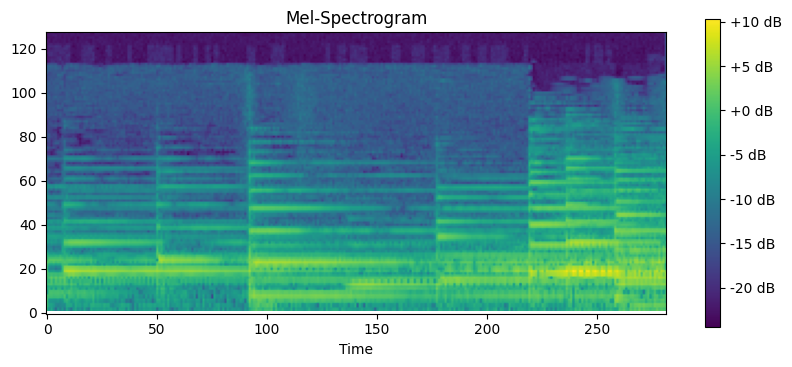

In [10]:
import torchaudio
import torch
import matplotlib.pyplot as plt
import numpy as np

def audio_to_melspectrogram(audio_path, n_fft=1024, win_length=None, hop_length=None, n_mels=128, f_min=0.0, f_max=None):
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform = torch.mean(waveform, dim=0, keepdim=True)
    waveform = get_trimmed_waveform(waveform, sample_rate, 3, trim_area='random')
    print(sample_rate)
    print(waveform.shape)

    mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        n_mels=n_mels,
        f_min=f_min,
        f_max=f_max
    )

    mel_spectrogram = mel_spectrogram_transform(waveform[0])

    return mel_spectrogram

def plot_melspectrogram(mel_spectrogram, sample_rate, title='Mel-Spectrogram'):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram.log2().detach().numpy(), cmap='viridis', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    # plt.ylabel('Mel Frequency')
    plt.show()

# Example usage
audio_path = 'cache/data/musiccaps/waveform/-0Gj8-vB1q4.wav'
mel_spectrogram = audio_to_melspectrogram(audio_path)
plot_melspectrogram(mel_spectrogram, sample_rate=mel_spectrogram.shape[1])

In [3]:
mel_spectrogram.shape

torch.Size([128, 1873])

In [11]:
mel_spectrogram.shape

torch.Size([128, 282])

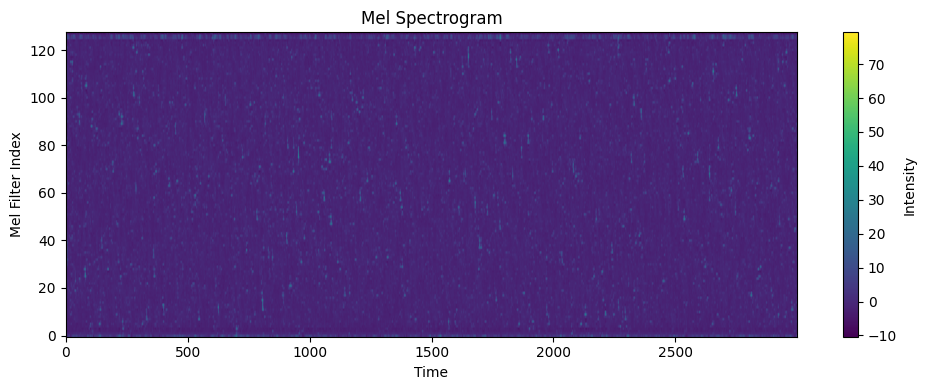

In [6]:
import torch
import matplotlib.pyplot as plt

# Load the tensor
tensor_location = "model_checkpoints/run_20240403_154046/samples/sample_0.pt"
mel_spec = torch.load(tensor_location)
mel_spec = mel_spec.squeeze()

# Convert tensor to numpy array
mel_spec_np = mel_spec.numpy()

# Plot the mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_np, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='Intensity')
plt.xlabel('Time')
plt.ylabel('Mel Filter Index')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()


### Testing MusicLang

In [2]:
from musiclang.library import *

# Write a C major chord (First degree of C major scale)
score = (I % I.M)(piano=[s0, s2, s4])

# Store it to midi
score.to_midi('c_major.mid')

/home/timoh/.local/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,EVENT_TYPE,OFFSET,PITCH,VELOCITY,DURATION,DELTA,TRACK,TEMPO,PEDAL
0,NOTE_ON,0,60,66,1,0,0,None,None
1,NOTE_ON,0,64,66,1,0,0,None,None
2,NOTE_ON,0,67,66,1,0,0,None,None
0,NOTE_OFF,1,60,66,1,1,0,None,None
1,NOTE_OFF,1,64,66,1,0,0,None,None
2,NOTE_OFF,1,67,66,1,0,0,None,None


In [3]:
from musiclang.library import *

# Create a cool melody (the beginning of happy birthday, independant of any harmonic context)
melody = s4.ed + s4.s + s5 + s4 + s0.o(1) + s6.h

# Create a simple accompaniment with a cello and a oboe
acc_melody = r + s0.o(-1).q * 3 + s0.o(-1).h
accomp = {'cello__0': acc_melody, 'oboe__0': acc_melody.o(1)}

# Play it in F-major
score = (I % IV.M)(violin__0=melody, **accomp)

# Repeat the score a second time in F-minor and forte
score += (score % I.m).f

# Just to create an anachrusis at the first bar
score = (I % I.M)(violin__0=r.h) + score

# Transform a bit the accompaniment by applying counterpoint rules automatically
score = score.get_counterpoint(fixed_parts=['violin__0'])

# Save it to musicxml
score.to_musicxml('happy_birthday.musicxml', signature=(3, 4), title='Happy birthday !')

In [2]:
len(ytid_to_remove)

116

### Just parsing output logs

In [4]:
tmp = """
Filter: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5521/5521 [00:00<00:00, 38043.78 examples/s]
Processing and downloading musiccaps clips.:  12%|█████████████████████████████████▎                                                                                                                                                                                                                                                       | 653/5513 [00:00<00:02, 1855.42it/s]ERROR:root:Failed to download or process file for ytid: 5Y_mT93tkvQ
Processing and downloading musiccaps clips.:  12%|█████████████████████████████████▎                                                                                                                                                                                                                                                       | 653/5513 [00:18<00:02, 1855.42it/s]ERROR:root:Failed to download or process file for ytid: 63rqIYPHvlc
Processing and downloading musiccaps clips.:  15%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                 | 806/5513 [00:22<03:17, 23.86it/s]ERROR:root:Failed to download or process file for ytid: 7B1OAtD_VIA
Processing and downloading musiccaps clips.:  15%|█████████████████████████████████████████▎                                                                                                                                                                                                                                                 | 806/5513 [00:38<03:17, 23.86it/s]ERROR:root:Failed to download or process file for ytid: 7LGLhQFiE0s
Processing and downloading musiccaps clips.:  15%|██████████████████████████████████████████▎                                                                                                                                                                                                                                                | 825/5513 [00:44<09:22,  8.34it/s]ERROR:root:Failed to download or process file for ytid: 7WZwlOrRELI
Processing and downloading musiccaps clips.:  15%|███████████████████████████████████████████▍                                                                                                                                                                                                                                               | 845/5513 [00:53<11:34,  6.72it/s]ERROR:root:Failed to download or process file for ytid: 8ZK1ajW598M
Processing and downloading musiccaps clips.:  15%|███████████████████████████████████████████▍                                                                                                                                                                                                                                               | 845/5513 [01:08<11:34,  6.72it/s]ERROR:root:Failed to download or process file for ytid: 8hT2G2ew6-c
Processing and downloading musiccaps clips.:  17%|███████████████████████████████████████████████▋                                                                                                                                                                                                                                           | 929/5513 [01:11<13:16,  5.76it/s]ERROR:root:Failed to download or process file for ytid: 8olHAhUKkuk
Processing and downloading musiccaps clips.:  19%|████████████████████████████████████████████████████▊                                                                                                                                                                                                                                     | 1032/5513 [01:20<09:09,  8.16it/s]ERROR:root:Failed to download or process file for ytid: AFWy1qyyMHE
Processing and downloading musiccaps clips.:  20%|████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 1108/5513 [01:29<09:02,  8.13it/s]ERROR:root:Failed to download or process file for ytid: AaUZb-iRStE
Processing and downloading musiccaps clips.:  20%|████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                 | 1108/5513 [01:40<09:02,  8.13it/s]ERROR:root:Failed to download or process file for ytid: Ah_aYOGnQ_I
Processing and downloading musiccaps clips.:  21%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                               | 1148/5513 [01:47<13:43,  5.30it/s]ERROR:root:Failed to download or process file for ytid: B7iRvj8y9aU
Processing and downloading musiccaps clips.:  22%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                            | 1200/5513 [01:58<13:46,  5.22it/s]ERROR:root:Failed to download or process file for ytid: BKQYrrJVg6g
Processing and downloading musiccaps clips.:  22%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                           | 1220/5513 [02:18<16:08,  4.43it/s]ERROR:root:Failed to download or process file for ytid: BeFzozm_H5M
Processing and downloading musiccaps clips.:  23%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                         | 1263/5513 [02:19<17:06,  4.14it/s]ERROR:root:Failed to download or process file for ytid: BiQik0xsWxk
Processing and downloading musiccaps clips.:  23%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                                                         | 1271/5513 [02:29<22:05,  3.20it/s]ERROR:root:Failed to download or process file for ytid: C7OIuhWSbjU
Processing and downloading musiccaps clips.:  24%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                      | 1325/5513 [02:50<17:52,  3.90it/s]ERROR:root:Failed to download or process file for ytid: CCFYOw8keiI
Processing and downloading musiccaps clips.:  24%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                     | 1333/5513 [02:52<25:46,  2.70it/s]ERROR:root:Failed to download or process file for ytid: Czbi1u-gwUU
Processing and downloading musiccaps clips.:  26%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 1417/5513 [03:02<16:02,  4.26it/s]ERROR:root:Failed to download or process file for ytid: DHDn79ee98Q
Processing and downloading musiccaps clips.:  28%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                          | 1559/5513 [03:13<08:08,  8.09it/s]ERROR:root:Failed to download or process file for ytid: EhFWLbNBOxc
Processing and downloading musiccaps clips.:  29%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                        | 1604/5513 [03:23<09:27,  6.88it/s]ERROR:root:Failed to download or process file for ytid: FYwDTJtEzhk
Processing and downloading musiccaps clips.:  30%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                      | 1642/5513 [03:32<10:48,  5.97it/s]ERROR:root:Failed to download or process file for ytid: FtskdD6Py7Y
Processing and downloading musiccaps clips.:  30%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                    | 1665/5513 [03:44<14:25,  4.44it/s]ERROR:root:Failed to download or process file for ytid: Fv9swdLA-lo
Processing and downloading musiccaps clips.:  31%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                  | 1722/5513 [03:56<11:57,  5.28it/s]ERROR:root:Failed to download or process file for ytid: HAHn_zB47ig
Processing and downloading musiccaps clips.:  32%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                               | 1770/5513 [04:05<12:04,  5.17it/s]ERROR:root:Failed to download or process file for ytid: Hvs6Xwc6-gc
Processing and downloading musiccaps clips.:  33%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                           | 1841/5513 [04:15<10:10,  6.01it/s]ERROR:root:Failed to download or process file for ytid: IF-77lLlMzE
Processing and downloading musiccaps clips.:  34%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                          | 1876/5513 [04:24<11:35,  5.23it/s]ERROR:root:Failed to download or process file for ytid: IbJh1xeBFcI
Processing and downloading musiccaps clips.:  35%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                        | 1914/5513 [04:34<12:19,  4.87it/s]ERROR:root:Failed to download or process file for ytid: InfQUMh935c
Processing and downloading musiccaps clips.:  35%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                       | 1933/5513 [04:42<14:45,  4.04it/s]ERROR:root:Failed to download or process file for ytid: JNw0A8pRnsQ
Processing and downloading musiccaps clips.:  36%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 1989/5513 [04:51<12:22,  4.74it/s]ERROR:root:Failed to download or process file for ytid: Jk2mvFrdZTU
Processing and downloading musiccaps clips.:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 2119/5513 [05:01<06:19,  8.95it/s]ERROR:root:Failed to download or process file for ytid: L5Uu_0xEZg4
Processing and downloading musiccaps clips.:  39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                            | 2151/5513 [05:11<08:28,  6.61it/s]ERROR:root:Failed to download or process file for ytid: LRfVQsnaVQE
Processing and downloading musiccaps clips.:  40%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 2180/5513 [05:21<10:29,  5.30it/s]ERROR:root:Failed to download or process file for ytid: MYtq46rNsCA
Processing and downloading musiccaps clips.:  41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                     | 2272/5513 [05:30<07:52,  6.85it/s]ERROR:root:Failed to download or process file for ytid: NIcsJ8sEd0M
Processing and downloading musiccaps clips.:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 2320/5513 [05:40<08:43,  6.10it/s]ERROR:root:Failed to download or process file for ytid: OS4YFp3DiEE
Processing and downloading musiccaps clips.:  48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 2632/5513 [06:00<02:26, 19.61it/s]ERROR:root:Failed to download or process file for ytid: RQ0-sjpAPKU
Processing and downloading musiccaps clips.:  49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 2691/5513 [06:01<03:58, 11.83it/s]ERROR:root:Failed to download or process file for ytid: Rqv5fu1PCXA
Processing and downloading musiccaps clips.:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 2719/5513 [06:12<05:51,  7.94it/s]ERROR:root:Failed to download or process file for ytid: RxBFh-zdid4
Processing and downloading musiccaps clips.:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 2723/5513 [06:23<08:53,  5.23it/s]ERROR:root:Failed to download or process file for ytid: SLq-Co_szYo
Processing and downloading musiccaps clips.:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 2754/5513 [06:32<09:59,  4.61it/s]ERROR:root:Failed to download or process file for ytid: T6iv9GFIVyU
Processing and downloading musiccaps clips.:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 2833/5513 [06:58<08:01,  5.56it/s]ERROR:root:Failed to download or process file for ytid: TkclVqlyKx4
Processing and downloading musiccaps clips.:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 2855/5513 [07:00<12:14,  3.62it/s]ERROR:root:Failed to download or process file for ytid: UOC4VWQpnDM
Processing and downloading musiccaps clips.:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 2904/5513 [07:15<12:21,  3.52it/s]ERROR:root:Failed to download or process file for ytid: UdA6I_tXVHE
Processing and downloading musiccaps clips.:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 2922/5513 [07:25<14:21,  3.01it/s]ERROR:root:Failed to download or process file for ytid: UzAXqTsdtjY
Processing and downloading musiccaps clips.:  54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 2956/5513 [07:36<14:09,  3.01it/s]ERROR:root:Failed to download or process file for ytid: Vi2posMLsrg
Processing and downloading musiccaps clips.:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 3014/5513 [07:45<10:29,  3.97it/s]ERROR:root:Failed to download or process file for ytid: Vu7ZUUl4VPc
Processing and downloading musiccaps clips.:  55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 3041/5513 [07:54<11:01,  3.74it/s]ERROR:root:Failed to download or process file for ytid: WKYUiLace9Y
Processing and downloading musiccaps clips.:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 3079/5513 [08:02<10:22,  3.91it/s]ERROR:root:Failed to download or process file for ytid: We0WIPYrtRE
Processing and downloading musiccaps clips.:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 3110/5513 [08:11<10:31,  3.80it/s]ERROR:root:Failed to download or process file for ytid: WvEtOYCShfM
Processing and downloading musiccaps clips.:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 3140/5513 [08:20<10:43,  3.69it/s]ERROR:root:Failed to download or process file for ytid: XCQMJXkI5bA
Processing and downloading musiccaps clips.:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 3158/5513 [08:29<12:20,  3.18it/s]ERROR:root:Failed to download or process file for ytid: Xoke1wUwEXY
Processing and downloading musiccaps clips.:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 3219/5513 [08:38<08:58,  4.26it/s]ERROR:root:Failed to download or process file for ytid: Xy7KtmHMQzU
Processing and downloading musiccaps clips.:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 3342/5513 [08:47<04:11,  8.63it/s]ERROR:root:Failed to download or process file for ytid: ZLDQ8-8AyI4
Processing and downloading musiccaps clips.:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 3377/5513 [09:08<05:18,  6.70it/s]ERROR:root:Failed to download or process file for ytid: Zs3arUuPciY
Processing and downloading musiccaps clips.:  62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 3413/5513 [09:10<07:14,  4.84it/s]ERROR:root:Failed to download or process file for ytid: _ACyiKGpD8Y
Processing and downloading musiccaps clips.:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 3441/5513 [09:23<08:56,  3.86it/s]ERROR:root:Failed to download or process file for ytid: _DHMdtRRJzE
Processing and downloading musiccaps clips.:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 3529/5513 [09:32<05:03,  6.54it/s]ERROR:root:Failed to download or process file for ytid: ab8V7MYQVyg
Processing and downloading musiccaps clips.:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 3566/5513 [09:42<05:54,  5.49it/s]ERROR:root:Failed to download or process file for ytid: asYb6iDz_kM
Processing and downloading musiccaps clips.:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 3593/5513 [09:53<07:29,  4.27it/s]ERROR:root:Failed to download or process file for ytid: ba3QPheW8mI
Processing and downloading musiccaps clips.:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 3629/5513 [10:02<07:28,  4.20it/s]ERROR:root:Failed to download or process file for ytid: bpwO0lbJPF4
Processing and downloading musiccaps clips.:  66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 3648/5513 [10:12<08:50,  3.51it/s]ERROR:root:Failed to download or process file for ytid: cADT8fUucLQ
Processing and downloading musiccaps clips.:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 3678/5513 [10:21<08:56,  3.42it/s]ERROR:root:Failed to download or process file for ytid: d0Uz_RnRV88
Processing and downloading musiccaps clips.:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 3747/5513 [10:31<06:23,  4.60it/s]ERROR:root:Failed to download or process file for ytid: d6-bQMCz7j0
Processing and downloading musiccaps clips.:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 3754/5513 [10:40<08:36,  3.40it/s]ERROR:root:Failed to download or process file for ytid: dcY062mkf9g
Processing and downloading musiccaps clips.:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 3796/5513 [11:00<07:37,  3.75it/s]ERROR:root:Failed to download or process file for ytid: dsVzafZik3c
Processing and downloading musiccaps clips.:  69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 3814/5513 [11:02<09:50,  2.88it/s]ERROR:root:Failed to download or process file for ytid: eHeUipPZHIc
Processing and downloading musiccaps clips.:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 3845/5513 [11:14<10:01,  2.77it/s]ERROR:root:Failed to download or process file for ytid: ed-1zAOr9PQ
Processing and downloading musiccaps clips.:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 3879/5513 [11:24<09:10,  2.97it/s]ERROR:root:Failed to download or process file for ytid: fZyq2pM2-dI
Processing and downloading musiccaps clips.:  72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 3953/5513 [11:33<05:58,  4.35it/s]ERROR:root:Failed to download or process file for ytid: fwXh_lMOqu0
Processing and downloading musiccaps clips.:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 3984/5513 [11:44<06:32,  3.90it/s]ERROR:root:Failed to download or process file for ytid: g8USMvt9np0
Processing and downloading musiccaps clips.:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 4000/5513 [11:56<08:21,  3.01it/s]ERROR:root:Failed to download or process file for ytid: gdtw54I8soM
Processing and downloading musiccaps clips.:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 4034/5513 [12:10<08:36,  2.87it/s]ERROR:root:Failed to download or process file for ytid: go_7i6WvfeE
Processing and downloading musiccaps clips.:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 4078/5513 [12:22<06:53,  3.47it/s]ERROR:root:Failed to download or process file for ytid: hwp7wCKIXg4
Processing and downloading musiccaps clips.:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 4145/5513 [12:31<04:52,  4.68it/s]ERROR:root:Failed to download or process file for ytid: iXgEQj1Fs7g
Processing and downloading musiccaps clips.:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 4188/5513 [12:40<04:40,  4.73it/s]ERROR:root:Failed to download or process file for ytid: idVCpQaByc4
Processing and downloading musiccaps clips.:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 4202/5513 [12:52<06:21,  3.44it/s]ERROR:root:Failed to download or process file for ytid: itgeNVRhBKs
Processing and downloading musiccaps clips.:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 4214/5513 [13:00<07:37,  2.84it/s]ERROR:root:Failed to download or process file for ytid: j9hAUlz5kQs
Processing and downloading musiccaps clips.:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 4232/5513 [13:20<08:12,  2.60it/s]ERROR:root:Failed to download or process file for ytid: jd1IS7N3u0I
Processing and downloading musiccaps clips.:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 4259/5513 [13:21<08:18,  2.51it/s]ERROR:root:Failed to download or process file for ytid: jmPmqzxlOTY
Processing and downloading musiccaps clips.:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 4274/5513 [13:30<09:12,  2.24it/s]ERROR:root:Failed to download or process file for ytid: k-LkhT4HAiE
Processing and downloading musiccaps clips.:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 4285/5513 [13:41<11:01,  1.86it/s]ERROR:root:Failed to download or process file for ytid: keIvA2wSPZc
Processing and downloading musiccaps clips.:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 4331/5513 [13:54<07:59,  2.46it/s]ERROR:root:Failed to download or process file for ytid: kiu-40_T5nY
Processing and downloading musiccaps clips.:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 4340/5513 [14:03<09:30,  2.06it/s]ERROR:root:Failed to download or process file for ytid: lTLsL94ABRs
Processing and downloading musiccaps clips.:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 4393/5513 [14:16<06:37,  2.82it/s]ERROR:root:Failed to download or process file for ytid: lrk00BNiuD4
Processing and downloading musiccaps clips.:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 4419/5513 [14:28<06:59,  2.61it/s]ERROR:root:Failed to download or process file for ytid: m-e3w2yZ6sM
Processing and downloading musiccaps clips.:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 4532/5513 [14:40<02:50,  5.75it/s]ERROR:root:Failed to download or process file for ytid: nTtxF9Wyw6o
Processing and downloading musiccaps clips.:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 4564/5513 [14:53<03:30,  4.50it/s]ERROR:root:Failed to download or process file for ytid: opu2tXoVNKU
Processing and downloading musiccaps clips.:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 4749/5513 [15:05<01:10, 10.90it/s]ERROR:root:Failed to download or process file for ytid: qIxpfaeZ-zs
Processing and downloading musiccaps clips.:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 4789/5513 [15:16<01:37,  7.44it/s]ERROR:root:Failed to download or process file for ytid: qc1DaM4kdO0
Processing and downloading musiccaps clips.:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 4794/5513 [15:26<02:31,  4.76it/s]ERROR:root:Failed to download or process file for ytid: qyCea2TuUV4
Processing and downloading musiccaps clips.:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4832/5513 [15:40<02:53,  3.93it/s]ERROR:root:Failed to download or process file for ytid: rQeikHMQGOM
Processing and downloading musiccaps clips.:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4868/5513 [15:50<02:52,  3.75it/s]ERROR:root:Failed to download or process file for ytid: rfah0bhmYkc
Processing and downloading musiccaps clips.:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4977/5513 [16:01<01:17,  6.90it/s]ERROR:root:Failed to download or process file for ytid: t5fW1-6iXZY
Processing and downloading musiccaps clips.:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4977/5513 [16:18<01:17,  6.90it/s]ERROR:root:Failed to download or process file for ytid: tEZU-ZRhSoY
Processing and downloading musiccaps clips.:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 5009/5513 [16:23<02:11,  3.82it/s]ERROR:root:Failed to download or process file for ytid: tju-t_Bz_W8
Processing and downloading musiccaps clips.:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5051/5513 [16:35<02:05,  3.69it/s]ERROR:root:Failed to download or process file for ytid: tpamd6BKYU4
Processing and downloading musiccaps clips.:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 5155/5513 [16:50<01:01,  5.86it/s]ERROR:root:Failed to download or process file for ytid: vOAXAoHtl7o
Processing and downloading musiccaps clips.:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 5155/5513 [17:08<01:01,  5.86it/s]ERROR:root:Failed to download or process file for ytid: vQHKa69Mkzo
Processing and downloading musiccaps clips.:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 5174/5513 [17:13<01:46,  3.18it/s]ERROR:root:Failed to download or process file for ytid: vVNWjq9byoQ
Processing and downloading musiccaps clips.:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 5178/5513 [17:24<02:17,  2.43it/s]ERROR:root:Failed to download or process file for ytid: vsDriIwNAmU
Processing and downloading musiccaps clips.:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 5206/5513 [17:36<02:07,  2.41it/s]ERROR:root:Failed to download or process file for ytid: wBe5tW8iJew
Processing and downloading musiccaps clips.:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 5238/5513 [17:45<01:42,  2.67it/s]ERROR:root:Failed to download or process file for ytid: wSeT9dlfDTc
Processing and downloading musiccaps clips.:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 5286/5513 [17:57<01:14,  3.06it/s]ERROR:root:Failed to download or process file for ytid: xxCnmao8FAs
Processing and downloading musiccaps clips.:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 5359/5513 [18:10<00:39,  3.92it/s]ERROR:root:Failed to download or process file for ytid: yzT9nsHslAk
Processing and downloading musiccaps clips.:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5442/5513 [18:20<00:13,  5.08it/s]ERROR:root:Failed to download or process file for ytid: z4ewUsnIJKI
Processing and downloading musiccaps clips.:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 5442/5513 [18:38<00:13,  5.08it/s]ERROR:root:Failed to download or process file for ytid: zCrpaLEq1VQ
Processing and downloading musiccaps clips.:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5455/5513 [18:39<00:17,  3.26it/s]ERROR:root:Failed to download or process file for ytid: zSSIGv82318
Processing and downloading musiccaps clips.:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 5470/5513 [18:49<00:15,  2.86it/s]ERROR:root:Failed to download or process file for ytid: zSq2D_GF00o
Processing and downloading musiccaps clips.: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5513/5513 [18:58<00:00,  4.84it/s]
"""


In [7]:
import re

pattern = r"Failed to download or process file for ytid: (\S+)"

# Find all matches in the text
ids = re.findall(pattern, tmp)

In [11]:
ids

['5Y_mT93tkvQ',
 '63rqIYPHvlc',
 '7B1OAtD_VIA',
 '7LGLhQFiE0s',
 '7WZwlOrRELI',
 '8ZK1ajW598M',
 '8hT2G2ew6-c',
 '8olHAhUKkuk',
 'AFWy1qyyMHE',
 'AaUZb-iRStE',
 'Ah_aYOGnQ_I',
 'B7iRvj8y9aU',
 'BKQYrrJVg6g',
 'BeFzozm_H5M',
 'BiQik0xsWxk',
 'C7OIuhWSbjU',
 'CCFYOw8keiI',
 'Czbi1u-gwUU',
 'DHDn79ee98Q',
 'EhFWLbNBOxc',
 'FYwDTJtEzhk',
 'FtskdD6Py7Y',
 'Fv9swdLA-lo',
 'HAHn_zB47ig',
 'Hvs6Xwc6-gc',
 'IF-77lLlMzE',
 'IbJh1xeBFcI',
 'InfQUMh935c',
 'JNw0A8pRnsQ',
 'Jk2mvFrdZTU',
 'L5Uu_0xEZg4',
 'LRfVQsnaVQE',
 'MYtq46rNsCA',
 'NIcsJ8sEd0M',
 'OS4YFp3DiEE',
 'RQ0-sjpAPKU',
 'Rqv5fu1PCXA',
 'RxBFh-zdid4',
 'SLq-Co_szYo',
 'T6iv9GFIVyU',
 'TkclVqlyKx4',
 'UOC4VWQpnDM',
 'UdA6I_tXVHE',
 'UzAXqTsdtjY',
 'Vi2posMLsrg',
 'Vu7ZUUl4VPc',
 'WKYUiLace9Y',
 'We0WIPYrtRE',
 'WvEtOYCShfM',
 'XCQMJXkI5bA',
 'Xoke1wUwEXY',
 'Xy7KtmHMQzU',
 'ZLDQ8-8AyI4',
 'Zs3arUuPciY',
 '_ACyiKGpD8Y',
 '_DHMdtRRJzE',
 'ab8V7MYQVyg',
 'asYb6iDz_kM',
 'ba3QPheW8mI',
 'bpwO0lbJPF4',
 'cADT8fUucLQ',
 'd0Uz_RnRV88',
 'd6-bQM

### For Presentation


In [2]:
import torch
from tqdm import tqdm
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import numpy as np
from diffusers import DDPMScheduler

/home/timoh/anaconda3/envs/GEN_MUSIC/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# Assuming 'image.png' is your starting image
img = Image.open('image.png')
img_tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).unsqueeze(0).float() / 255

scheduler = DDPMScheduler(beta_start=0.02, beta_end=3)
model = None 

selected_timesteps = np.arange(0, 1000, 100) 

for timestep in tqdm(selected_timesteps):
    noise = torch.randn_like(img_tensor) * np.sqrt(scheduler.betas[timestep])
    noisy_img = img_tensor + noise

    generated_img = noisy_img.clamp(0, 1)

    generated_img_pil = Image.fromarray((generated_img.squeeze().permute(1, 2, 0).numpy() * 255).astype(np.uint8))
    generated_img_pil.save(f'sample_images/generated_image_{timestep}.png')


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


In [36]:
from PIL import Image
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
from diffusers import DDPMScheduler

# Assuming 'image.png' is your starting image
img = Image.open('sample_images/noised_mel_spectrogram.png').convert('L')  # Convert to grayscale ('L' mode)
img_tensor = torch.from_numpy(np.array(img)).unsqueeze(0).unsqueeze(0).float() / 255  # Shape (1, 1, H, W)

scheduler = DDPMScheduler(beta_start=0.0001, beta_end=0.2)
model = None  # Assuming you have a model to generate or denoise images

selected_timesteps = np.arange(0, 1000, 100)

for timestep in tqdm(selected_timesteps):
    noise = torch.randn_like(img_tensor) * np.sqrt(scheduler.betas[timestep])
    noisy_img = img_tensor + noise

    generated_img = noisy_img.clamp(0, 1)

    # Since it's a 1-channel image, remove the channel dimension when saving it
    generated_img_pil = Image.fromarray((generated_img.squeeze().numpy() * 255).astype(np.uint8))
    generated_img_pil.save(f'sample_images/noised_mel_spectrogram_0{timestep}.png')


100%|██████████| 10/10 [00:00<00:00, 404.80it/s]


In [50]:
from pydub import AudioSegment

# Load the MP3 file
audio = AudioSegment.from_mp3("sample_images/daft_punk.mp3")

# Define start and end times in milliseconds
start_time = 1 * 60 * 1000 + 33 * 1000 + 1700  # 1 minute, 33.5 seconds
end_time = start_time + 3000  # 3 seconds later

# Extract the clip
clip = audio[start_time:end_time]

# Export the clip to a new file
clip.export("sample_images/daft_punk_clip.mp3", format="mp3")


<_io.BufferedRandom name='sample_images/daft_punk_clip.mp3'>

In [55]:
import torch
import numpy as np
import librosa
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io.wavfile import write
from torchvision.transforms.functional import to_pil_image

# Your waveform and sampling rate loading logic here
waveform, sr = librosa.load("sample_images/daft_punk_clip.mp3", sr=None)

# Ensure the waveform and Mel spectrogram are in tensor format
waveform_tensor = torch.FloatTensor(waveform).unsqueeze(0).unsqueeze(0)  # Add channel and batch dimensions

scheduler = DDPMScheduler(beta_start=0.1, beta_end=0.9)
selected_timesteps = np.arange(0, 1000, 100)

for timestep in selected_timesteps:
    # Apply noise to waveform
    noise_waveform = torch.randn_like(waveform_tensor) * np.sqrt(scheduler.betas[timestep])
    noisy_waveform = waveform_tensor + noise_waveform
    write(f'sample_images/noised_waveform_{timestep}.wav', sr, noisy_waveform.squeeze().numpy())

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import glob
import os

# List all .wav files in the sample_images directory
wav_files = glob.glob('sample_images/*900.wav')

for wav_file in tqdm(wav_files):
    # Extract file name without the directory path and extension
    file_name = os.path.basename(wav_file).split('.')[0]

    # Load your WAV file
    samplerate, data = wavfile.read(wav_file)

    # Handle stereo audio by taking one channel
    if data.ndim > 1:
        data = data[:, 0]

    # Normalize data
    data = data / np.max(np.abs(data))

    # Plotting the waveform
    plt.figure(figsize=(20, 4), frameon=False)
    plt.plot(data, color='black')
    plt.axis('off')  # This removes the axis and labels
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    # Save the figure with a file name based on the original wav file
    output_file_name = f'sample_images/{file_name}_waveform.png'
    plt.savefig(output_file_name, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the plot to free memory for the next iteration


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]
